In [1]:
from pathlib import Path

import numpy as np
import pandas as pd


from masim_analysis import analysis, utils
from masim_analysis.configure import CountryParams


from ruamel.yaml import YAML


yaml = YAML()

country = CountryParams.load("moz")
country_code = "moz"


output = Path("output") / "moz"

In [2]:
ave_cases = pd.read_csv(output / "validation" / "ave_cases.csv", index_col=0)
ave_pfpr = pd.read_csv(output / "validation" / "ave_prevalence_2_to_10.csv", index_col=0)
ave_population = pd.read_csv(output / "validation" / "ave_population.csv", index_col=0)

In [3]:
ave_pfpr.drop(columns=["pfpr2to10"], inplace=True)

In [4]:
cases_2023 = ave_cases.loc[ave_cases["monthlydataid"].between(144, 155)].copy()
pfpr_2023 = ave_pfpr.loc[ave_pfpr["monthlydataid"].between(144, 155)].copy()
cases_2023.drop(columns=["clinicalepisodes"], inplace=True)
population_2023 = ave_population.loc[ave_population["monthlydataid"].between(144, 155)].copy()
population_2023.drop(columns=["population"], inplace=True)

In [5]:
cases_2023_monthly = cases_2023.groupby(["monthlydataid", "locationid"]).sum()
pfpr_2023_monthly = pfpr_2023.groupby(["monthlydataid", "locationid"]).mean()
population_2023_monthly = population_2023.groupby(["monthlydataid", "locationid"]).mean()

In [6]:
cases_2023_mean = cases_2023_monthly.groupby("locationid").sum()
cases_2023_mean["cases"] = cases_2023_mean.mean(axis=1)

In [7]:
pfpr_2023_mean = pfpr_2023_monthly.groupby("locationid").mean()
pfpr_2023_mean["pfpr2to10"] = pfpr_2023_mean.mean(axis=1)

In [8]:
population_2023_mean = population_2023_monthly.groupby("locationid").mean()
population_2023_mean["population"] = population_2023_mean.mean(axis=1)

In [9]:
print(f"Total cases in 2023: {cases_2023_mean[['cases']].sum().values[0] * 4:,}")

Total cases in 2023: 18,567,484.0


In [10]:
district_raster, meta = utils.read_raster(Path("data") / country_code / "moz_districts.asc")
district_mapping = pd.read_csv("data/moz/moz_mapping.csv", index_col=0)

In [11]:
pixel_ids = district_raster[~np.isnan(district_raster)].flatten()

In [12]:
pixel_mappings = pd.DataFrame({"district": pixel_ids}, index=pd.Index(np.arange(len(pixel_ids)), name="locationid"))

In [13]:
sim_results = cases_2023_mean["cases"].copy().to_frame()
sim_results = sim_results.merge(pfpr_2023_mean["pfpr2to10"].copy(), left_index=True, right_index=True, how="left")
sim_results = sim_results.merge(
    population_2023_mean["population"].copy(), left_index=True, right_index=True, how="left"
)
sim_results = sim_results.merge(pixel_mappings, left_index=True, right_index=True, how="left")
sim_results

,cases,pfpr2to10,population,district
locationid,,,,
0,8.326531,16.410929,11.666035,1.0
1,5.183673,2.599629,48.681629,1.0
2,3.959184,3.160845,25.326010,1.0
3,2.530612,4.954088,12.010227,1.0
4,32.836735,17.818432,45.915057,1.0
...,...,...,...,...
32006,25.714286,8.465329,66.560953,7.0
32007,27.734694,6.334947,98.528788,7.0
32008,50.469388,7.020633,161.699400,7.0


In [14]:
sim_results_districts = sim_results.groupby("district")[["cases", "population"]].sum()
sim_results_districts.rename(columns={"cases": "cases_sim", "population": "pop_sim"}, inplace=True)
sim_results_districts["pfpr_sim"] = sim_results.groupby("district")["pfpr2to10"].mean().div(100)
sim_results_districts

,cases_sim,pop_sim,pfpr_sim
district,,,
1.0,394889.102041,5.810490e+05,0.184526
2.0,897468.673469,1.564019e+06,0.156336
3.0,335576.938776,5.717346e+05,0.173297
4.0,279827.897959,3.879767e+05,0.178867
5.0,240310.510204,3.998713e+05,0.170672
6.0,277877.938776,6.190143e+05,0.141500
7.0,414768.979592,8.720655e+05,0.137730
8.0,382631.918367,5.707175e+05,0.182231
9.0,441192.346939,9.162723e+05,0.126525


In [15]:
pfpr = utils.read_raster(Path("data") / country_code / "moz_pfpr210.asc")[0]
pfpr_flat = pfpr[~np.isnan(district_raster)].flatten()

pop = utils.read_raster(Path("data") / country_code / "moz_population.asc")[0]
pop_flat = pop[~np.isnan(district_raster)].flatten()

In [16]:
obs = pd.DataFrame(
    {"district": pixel_ids, "pfpr_obs": pfpr_flat}, index=pd.Index(np.arange(len(pixel_ids)), name="locationid")
)
obs["pop_obs"] = pop_flat

In [17]:
obs

,district,pfpr_obs,pop_obs
locationid,,,
0,1.0,0.167382,31.0
1,1.0,0.000000,168.0
2,1.0,0.000000,81.0
3,1.0,0.000000,30.0
4,1.0,0.260931,171.0
...,...,...,...
32006,7.0,0.148126,230.0
32007,7.0,0.141393,341.0
32008,7.0,0.144309,590.0


In [ ]:
obs_districts = obs.groupby("district")[["pfpr_obs"]].mean()
obs_districts["pop_obs"] = obs.groupby("district")["pop_obs"].sum()
obs_districts

,pfpr_obs,pop_obs
district,,
1.0,0.318464,2302296.0
2.0,0.305419,6230069.0
3.0,0.294585,2187542.0
4.0,0.272032,1526236.0
5.0,0.285011,1549885.0
6.0,0.254787,2385916.0
7.0,0.248307,3479672.0
8.0,0.317886,2249210.0
9.0,0.243783,3545537.0


In [ ]:
pop_comparison = (
    obs_districts["pop_obs"]
    .to_frame()
    .merge(sim_results_districts["pop_sim"] * 4, left_index=True, right_index=True, how="left")
)
pop_comparison["diff"] = pop_comparison["pop_sim"] - pop_comparison["pop_obs"]
pop_comparison = pop_comparison.merge(district_mapping, left_index=True, right_index=True, how="left")
pop_comparison.loc["sum"] = pop_comparison.sum(numeric_only=True)
pop_comparison.to_csv("moz_population_comparison.csv")

In [ ]:
comparison = obs["pfpr_obs"]  # .merge(sim_results_districts, left_index=True, right_index=True, how="left")
comparison = comparison.to_frame().merge(
    pfpr_2023_mean["pfpr2to10"].div(100), left_index=True, right_index=True, how="left"
)
comparison.rename(columns={"pfpr2to10": "pfpr_sim"}, inplace=True)

comparison = comparison.merge(obs["district"], left_index=True, right_index=True, how="left")
comparison_out = (
    comparison.groupby("district").mean().merge(district_mapping, left_index=True, right_index=True, how="left")
)
comparison_out["difference"] = comparison_out["pfpr_obs"] - comparison_out["pfpr_sim"]
comparison_out.to_csv("moz_pfpr_comparison.csv")

In [21]:
comparison_out

,pfpr_obs,pfpr_sim,DISTRICT,difference
district,,,,
1.0,0.318464,0.184526,Cabo_Delgado,0.133939
2.0,0.305419,0.156336,Nampula,0.149083
3.0,0.294585,0.173297,Niassa,0.121288
4.0,0.272032,0.178867,Gaza,0.093164
5.0,0.285011,0.170672,Inhambane,0.114340
6.0,0.254787,0.141500,Manica,0.113288
7.0,0.248307,0.137730,Maputo,0.110578
8.0,0.317886,0.182231,Sofala,0.135655
9.0,0.243783,0.126525,Tete,0.117258


In [22]:
pfpr_sim = np.nan * np.ones(comparison.index[-1] + 1)
pfpr_sim[comparison.index.to_numpy()] = comparison["pfpr_sim"].to_numpy()
pfpr_sim_out = (np.nan * np.ones_like(pfpr)).flatten()
pfpr_sim_out[~np.isnan(pfpr.flatten())] = pfpr_sim
pfpr_sim_out = pfpr_sim_out.reshape(pfpr.shape)

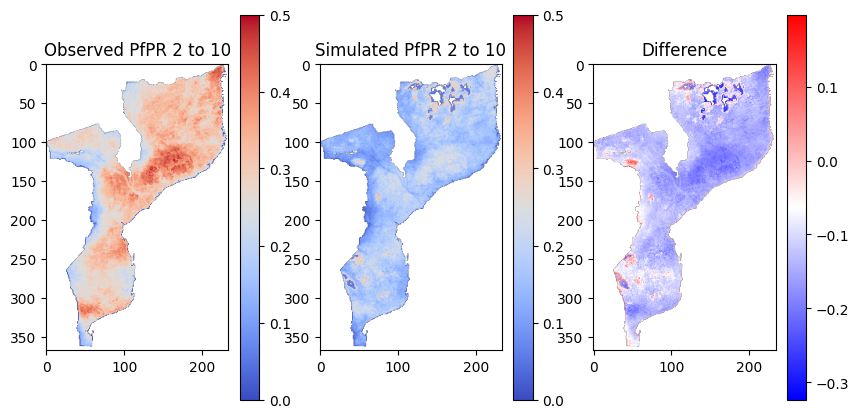

In [23]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
im0 = ax[0].imshow(pfpr, vmin=0, vmax=0.5, cmap="coolwarm")
ax[0].set_title("Observed PfPR 2 to 10")
fig.colorbar(im0, ax=ax[0])
im1 = ax[1].imshow(pfpr_sim_out, vmin=0, vmax=0.5, cmap="coolwarm")
ax[1].set_title("Simulated PfPR 2 to 10")
fig.colorbar(im1, ax=ax[1])
im2 = ax[2].imshow(pfpr_sim_out - pfpr, cmap="bwr")
ax[2].set_title("Difference")
fig.colorbar(im2, ax=ax[2])
fig.savefig("moz_pfpr_comparison.png", dpi=300)
plt.show()

In [24]:
moz_cases = pd.read_csv(Path("data") / country_code / "Cases 2023 2024.csv")

In [25]:
moz_2023 = moz_cases.loc[moz_cases["Ano"] == 2023].copy().groupby("district").sum()
moz_2023.drop(columns={"Ano", "Provincia"}, inplace=True)

In [26]:
moz_2023

,Unadjusted Anual Cases,Adjusted Anual Cases
district,,
1,886524,9.102682e+05
2,420115,4.204072e+05
3,849633,8.578615e+05
4,994826,9.980041e+05
5,44247,4.508204e+04
6,2305415,2.306073e+06
7,818360,8.306292e+05
8,1280319,1.294764e+06
9,763085,7.813600e+05


In [27]:
sim_results_districts

,cases_sim,pop_sim,pfpr_sim
district,,,
1.0,394889.102041,5.810490e+05,0.184526
2.0,897468.673469,1.564019e+06,0.156336
3.0,335576.938776,5.717346e+05,0.173297
4.0,279827.897959,3.879767e+05,0.178867
5.0,240310.510204,3.998713e+05,0.170672
6.0,277877.938776,6.190143e+05,0.141500
7.0,414768.979592,8.720655e+05,0.137730
8.0,382631.918367,5.707175e+05,0.182231
9.0,441192.346939,9.162723e+05,0.126525


In [28]:
moz_2023

,Unadjusted Anual Cases,Adjusted Anual Cases
district,,
1,886524,9.102682e+05
2,420115,4.204072e+05
3,849633,8.578615e+05
4,994826,9.980041e+05
5,44247,4.508204e+04
6,2305415,2.306073e+06
7,818360,8.306292e+05
8,1280319,1.294764e+06
9,763085,7.813600e+05


In [29]:
sim_results_districts.loc["sum"] = sim_results_districts.sum()

In [ ]:
case_comparison = moz_2023["Adjusted Anual Cases"].copy().to_frame()
case_comparison = case_comparison.merge(
    sim_results_districts[["cases_sim", "pop_sim"]] * 4, left_index=True, right_index=True, how="left"
)
case_comparison.rename(columns={"Adjusted Anual Cases": "observed_cases", "cases": "simulated_cases"}, inplace=True)
# case_comparison.loc["sum"] = case_comparison.sum()
# case_comparison["diff"] = case_comparison["simulated_cases"] - case_comparison["observed_cases"]
case_comparison = case_comparison.merge(district_mapping, left_index=True, right_index=True, how="left")
case_comparison["difference"] = case_comparison["observed_cases"] - case_comparison["cases_sim"]

case_comparison["sim_percentage"] = 100 * case_comparison["cases_sim"] / case_comparison["cases_sim"].sum()
case_comparison["obs_percentage"] = 100 * case_comparison["observed_cases"] / case_comparison["observed_cases"].sum()
case_comparison["diff_percentage"] = case_comparison["obs_percentage"] - case_comparison["sim_percentage"]

case_comparison.loc["sum"] = case_comparison.sum(numeric_only=True)

case_comparison.to_csv("moz_case_comparison.csv")

In [31]:
case_comparison

,observed_cases,cases_sim,pop_sim,DISTRICT,difference,sim_percentage,obs_percentage,diff_percentage
district,,,,,,,,
1,9.102682e+05,1.579556e+06,2.324196e+06,Cabo_Delgado,-6.692882e+05,8.507111,7.640172,-0.866938
2,4.204072e+05,3.589875e+06,6.256075e+06,Nampula,-3.169468e+06,19.334201,3.528612,-15.805589
3,8.578615e+05,1.342308e+06,2.286938e+06,Niassa,-4.844462e+05,7.229347,7.200306,-0.029040
4,9.980041e+05,1.119312e+06,1.551907e+06,Gaza,-1.213075e+05,6.028343,8.376568,2.348225
5,4.508204e+04,9.612420e+05,1.599485e+06,Inhambane,-9.161600e+05,5.177018,0.378388,-4.798630
6,2.306073e+06,1.111512e+06,2.476057e+06,Manica,1.194561e+06,5.986335,19.355605,13.369270
7,8.306292e+05,1.659076e+06,3.488262e+06,Maputo,-8.284467e+05,8.935384,6.971737,-1.963647
8,1.294764e+06,1.530528e+06,2.282870e+06,Sofala,-2.357634e+05,8.243054,10.867371,2.624317
9,7.813600e+05,1.764769e+06,3.665089e+06,Tete,-9.834094e+05,9.504623,6.558204,-2.946419


In [32]:
case_comparison_percentage = case_comparison.copy()

In [33]:
proportion_comparison = case_comparison.copy()
proportion_comparison["observed_proportion"] = (
    proportion_comparison["observed_cases"] / proportion_comparison["observed_cases"].sum()
)
proportion_comparison["simulated_proportion"] = (
    proportion_comparison["cases_sim"] / proportion_comparison["cases_sim"].sum()
)
proportion_comparison.drop(columns={"observed_cases", "cases_sim"}, inplace=True)
proportion_comparison

,pop_sim,DISTRICT,difference,sim_percentage,obs_percentage,diff_percentage,observed_proportion,simulated_proportion
district,,,,,,,,
1,2.324196e+06,Cabo_Delgado,-6.692882e+05,8.507111,7.640172,-0.866938,0.038201,0.042536
2,6.256075e+06,Nampula,-3.169468e+06,19.334201,3.528612,-15.805589,0.017643,0.096671
3,2.286938e+06,Niassa,-4.844462e+05,7.229347,7.200306,-0.029040,0.036002,0.036147
4,1.551907e+06,Gaza,-1.213075e+05,6.028343,8.376568,2.348225,0.041883,0.030142
5,1.599485e+06,Inhambane,-9.161600e+05,5.177018,0.378388,-4.798630,0.001892,0.025885
6,2.476057e+06,Manica,1.194561e+06,5.986335,19.355605,13.369270,0.096778,0.029932
7,3.488262e+06,Maputo,-8.284467e+05,8.935384,6.971737,-1.963647,0.034859,0.044677
8,2.282870e+06,Sofala,-2.357634e+05,8.243054,10.867371,2.624317,0.054337,0.041215
9,3.665089e+06,Tete,-9.834094e+05,9.504623,6.558204,-2.946419,0.032791,0.047523


In [34]:
proportion_comparison = proportion_comparison.merge(district_mapping, left_index=True, right_index=True, how="left")

In [35]:
proportion_comparison.to_csv("moz_case_proportion_comparison.csv")

In [36]:
case_comparison = case_comparison.merge(district_mapping, left_index=True, right_index=True, how="left")

In [37]:
case_comparison.to_csv("moz_case_comparison.csv")

In [38]:
from matplotlib import pyplot as plt

In [39]:
proportion_comparison

,pop_sim,DISTRICT_x,difference,sim_percentage,obs_percentage,diff_percentage,observed_proportion,simulated_proportion,DISTRICT_y
district,,,,,,,,,
1,2.324196e+06,Cabo_Delgado,-6.692882e+05,8.507111,7.640172,-0.866938,0.038201,0.042536,Cabo_Delgado
2,6.256075e+06,Nampula,-3.169468e+06,19.334201,3.528612,-15.805589,0.017643,0.096671,Nampula
3,2.286938e+06,Niassa,-4.844462e+05,7.229347,7.200306,-0.029040,0.036002,0.036147,Niassa
4,1.551907e+06,Gaza,-1.213075e+05,6.028343,8.376568,2.348225,0.041883,0.030142,Gaza
5,1.599485e+06,Inhambane,-9.161600e+05,5.177018,0.378388,-4.798630,0.001892,0.025885,Inhambane
6,2.476057e+06,Manica,1.194561e+06,5.986335,19.355605,13.369270,0.096778,0.029932,Manica
7,3.488262e+06,Maputo,-8.284467e+05,8.935384,6.971737,-1.963647,0.034859,0.044677,Maputo
8,2.282870e+06,Sofala,-2.357634e+05,8.243054,10.867371,2.624317,0.054337,0.041215,Sofala
9,3.665089e+06,Tete,-9.834094e+05,9.504623,6.558204,-2.946419,0.032791,0.047523,Tete


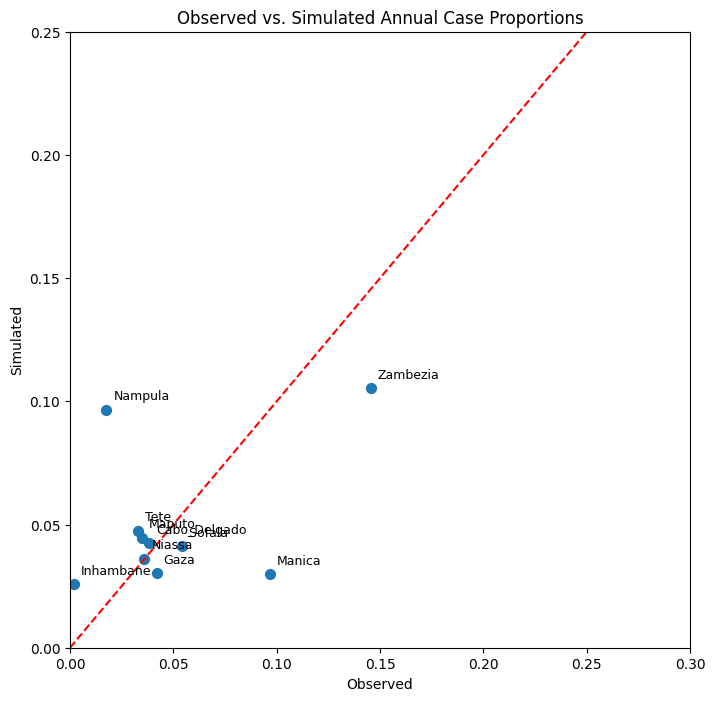

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))

# scatter points
x = proportion_comparison["observed_proportion"]
y = proportion_comparison["simulated_proportion"]
ax.scatter(x, y, s=50, color="C0")

# annotate each point with the district name (fall back to index if no name)
for idx in x.index:
    xi, yi = x.loc[idx], y.loc[idx]
    label = district_mapping.loc[idx, "DISTRICT"] if idx in district_mapping.index else str(idx)
    ax.annotate(label, (xi, yi), xytext=(5, 5), textcoords="offset points", fontsize=9, ha="left", va="bottom")
ax.plot(np.linspace(0, 1), np.linspace(0, 1), "r--")
ax.set_xlim((0, 0.3))
ax.set_ylim((0, 0.25))
ax.set_xlabel("Observed")
ax.set_ylabel("Simulated")
ax.set_title("Observed vs. Simulated Annual Case Proportions")
fig.savefig(Path("images") / "moz" / "proportions.png")

In [41]:
np.arange(0, 1, 1000)

array([0])

---

In [42]:
genotypes = analysis.get_table(output / "validation" / "moz_validation_scaled_0.37_monthly_data_0.db", "genotype")
genome_data = analysis.get_table(
    output / "validation" / "moz_validation_scaled_0.37_monthly_data_0.db", "monthlygenomedata"
)

In [43]:
genome_data.loc[genome_data["monthlydataid"] == 144]

,monthlydataid,locationid,genomeid,occurrences,clinicaloccurrences,occurrences0to5,occurrences2to10,weightedoccurrences
4848483,144,0,32,36,7,23,3,8.933333
4848484,144,0,36,1,0,1,0,0.066667
4848485,144,1,32,1,0,0,0,1.000000
4848486,144,1,36,1,0,1,1,1.000000
4848487,144,2,32,2,0,0,0,2.000000
...,...,...,...,...,...,...,...,...
4907833,144,32008,36,5,1,2,2,3.000000
4907834,144,32009,32,73,5,27,35,49.550000
4907835,144,32009,36,42,1,16,17,31.450000
4907836,144,32010,32,2,0,2,2,1.000000


In [44]:
genome_data_2022 = genome_data.copy().loc[genome_data["monthlydataid"].between(144, 155)]

In [45]:
genome_data_2022

,monthlydataid,locationid,genomeid,occurrences,clinicaloccurrences,occurrences0to5,occurrences2to10,weightedoccurrences
4848483,144,0,32,36,7,23,3,8.933333
4848484,144,0,36,1,0,1,0,0.066667
4848485,144,1,32,1,0,0,0,1.000000
4848486,144,1,36,1,0,1,1,1.000000
4848487,144,2,32,2,0,0,0,2.000000
...,...,...,...,...,...,...,...,...
5561969,155,32007,36,16,2,6,6,13.000000
5561970,155,32008,32,50,4,13,22,41.000000
5561971,155,32008,36,3,0,0,0,3.000000
5561972,155,32009,32,30,1,13,17,21.266667


In [46]:
genome_data_2022 = (
    genome_data_2022[
        ["genomeid", "occurrences", "clinicaloccurrences", "occurrences0to5", "occurrences2to10", "weightedoccurrences"]
    ]
    .groupby("genomeid")
    .sum()
)
genome_data_2022

,occurrences,clinicaloccurrences,occurrences0to5,occurrences2to10,weightedoccurrences
genomeid,,,,,
32,24329877,1309296,10033284,8774843,1.573298e+07
36,19143438,1025245,7899535,6917114,1.240421e+07


In [47]:
genotypes.loc[genotypes["id"] == 36]

,id,name
36,36,TYY--R1


In [48]:
genome_data_2022 = pd.DataFrame()

for file in output.glob("validation/*.db"):
    in_data = analysis.get_table(file, "monthlygenomedata")
    in_data_2022 = in_data.loc[in_data["monthlydataid"].between(144, 155)]
    in_data_2022_grouped = (
        in_data_2022[
            [
                "genomeid",
                "occurrences",
                "clinicaloccurrences",
                "occurrences0to5",
                "occurrences2to10",
                "weightedoccurrences",
            ]
        ]
        .groupby("genomeid")
        .sum()
    )
    genome_data_2022 = pd.concat([genome_data_2022, in_data_2022_grouped])

# genome_data_2022 = genome_data_2022.groupby("genomeid").mean()
genome_data_2022.to_csv(output / "validation" / "genome_data_2022_sum.csv")

/tmp/ipykernel_18497/1800666674.py:20: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  genome_data_2022 = pd.concat([genome_data_2022, in_data_2022_grouped])
/tmp/ipykernel_18497/1800666674.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  genome_data_2022 = pd.concat([genome_data_2022, in_data_2022_grouped])


In [49]:
genome_data_2022 = pd.read_csv(output / "validation" / "genome_data_2022_mean.csv", index_col=0)
genome_data_2022 = genome_data_2022.groupby("genomeid").mean() * 4
genome_data_2022 = genome_data_2022.merge(genotypes, left_index=True, right_on="id")
genome_data_2022 = genome_data_2022.drop(columns=["id"])
genome_data_2022

,occurrences,clinicaloccurrences,occurrences0to5,occurrences2to10,weightedoccurrences,name
32,267.928239,14.363223,110.618170,96.707271,173.386846,TNY--R1
36,219.363355,11.770177,90.549329,79.164566,141.970184,TYY--R1


In [50]:
genome_records = pd.read_csv("data/moz/moz genome data.csv")
genome_records = genome_records[
    ["gene", "locus", "allele", "n_total_samples_collected_day_0", "n_carriers_identified_day_0", "frequency"]
]
genome_records

,gene,locus,allele,n_total_samples_collected_day_0,n_carriers_identified_day_0,frequency
0,pfmdr1,184,Y,270,61,0.225926
1,pfmdr1,184,F,270,209,0.774074
2,pfcrt,76,K,273,272,0.996337
3,pfcrt,76,T,273,1,0.003663
4,pfmdr1,184,Y,343,101,0.294461
5,pfmdr1,184,F,343,242,0.705539
6,pfcrt,76,K,342,342,1.000000
7,pfcrt,76,T,342,0,0.000000
8,pfmdr1,184,Y,190,76,0.400000
9,pfmdr1,184,F,190,114,0.600000


### Reported Allele Frequencies in 2022

In [51]:
genome_records = genome_records.groupby(["gene", "locus", "allele"]).sum()
genome_records["frequency"] = (
    genome_records["n_carriers_identified_day_0"] / genome_records["n_total_samples_collected_day_0"]
)
genome_records

n_total_samples_collected_day_0  \
gene   locus allele                                    
pfcrt  76    K                                   804   
             T                                   804   
pfmdr1 184   F                                   803   
             Y                                   803   

                     n_carriers_identified_day_0  frequency  
gene   locus allele                                          
pfcrt  76    K                               803   0.998756  
             T                                 1   0.001244  
pfmdr1 184   F                               565   0.703611  
             Y                               238   0.296389

### Simulation Allele Frequencies in 2022

In [52]:
genome_data_2022["frequency"] = genome_data_2022["clinicaloccurrences"] / genome_data_2022["occurrences"]
genome_data_2022

,occurrences,clinicaloccurrences,occurrences0to5,occurrences2to10,weightedoccurrences,name,frequency
32,267.928239,14.363223,110.618170,96.707271,173.386846,TNY--R1,0.053608
36,219.363355,11.770177,90.549329,79.164566,141.970184,TYY--R1,0.053656


In [53]:
genome_data_2022["occurrences"].sum()

np.float64(487.29159461851225)

TNY--R1: pfcrt + pfmdr1

TYY--R1: pfcrt + pfmdr1

In [54]:
from masim_analysis import calibrate

In [55]:
models_map = calibrate.load_beta_model("data/moz/calibration/models_map.json")

In [56]:
population_raster, meta = utils.read_raster("data/moz/moz_population.asc")
access_rate_raster = utils.read_raster("data/moz/moz_treatmentseeking.asc")[0]
prevalence_raster = utils.read_raster("data/moz/moz_pfpr210.asc")[0]

In [57]:
beta_map = calibrate.create_beta_map(models_map, population_raster, access_rate_raster, prevalence_raster)

/home/james/Code/Temple-Malaria-Simulation-Analysis/src/masim_analysis/calibrate.py:577: RuntimeWarning: divide by zero encountered in scalar divide
  beta_log = c - (1 / b) * np.log(a / pfpr - 1)


In [58]:
utils.write_raster(beta_map, "output/moz/moz_beta_map.asc", meta["xllcorner"], meta["yllcorner"])

In [59]:
beta_raster = utils.read_raster("data/moz/moz_beta_scaled_0.37.asc")[0]

In [60]:
from matplotlib import pyplot as plt

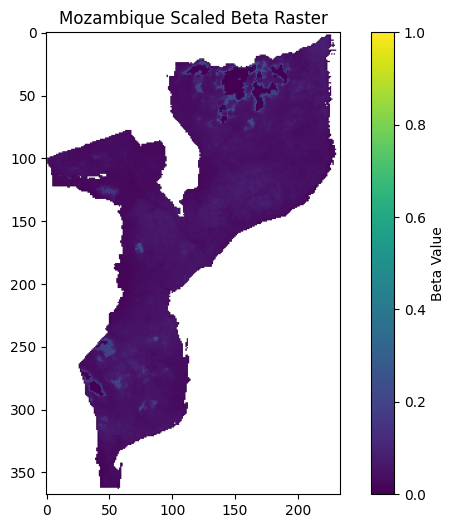

In [61]:
from matplotlib.pyplot import clim


fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(beta_map * 0.37, cmap="viridis")
im.set_clim(0, 1.0)
cbar = fig.colorbar(im, ax=ax, label="Beta Value")
ax.set_title("Mozambique Scaled Beta Raster")
fig.savefig("output/moz/moz_beta_map_scaled.png")
plt.show()

---

In [62]:
analysis.get_all_tables("moz_validation_scaled_0.37_mut_monthly_data_99.db")

['monthlydata',
 'sqlite_sequence',
 'monthlysitedata',
 'genotype',
 'monthlygenomedata']

In [63]:
genotype_data = analysis.get_table("moz_validation_scaled_0.37_monthly_data_1.db", "monthlygenomedata")

In [64]:
genotype_data

,monthlydataid,locationid,genomeid,occurrences,clinicaloccurrences,occurrences0to5,occurrences2to10,weightedoccurrences


In [65]:
genotype_data["genomeid"].unique()

array([], dtype=object)

In [66]:
monthlysitedata = analysis.get_table("moz_validation_scaled_0.37_monthly_data_1.db", "monthlysitedata")

In [67]:
monthlysitedata

,monthlydataid,locationid,population,clinicalepisodes,clinicalepisodes_by_age_class_0_1,clinicalepisodes_by_age_class_1_2,clinicalepisodes_by_age_class_2_3,clinicalepisodes_by_age_class_3_4,clinicalepisodes_by_age_class_4_5,clinicalepisodes_by_age_class_5_6,...,treatments,treatmentfailures,eir,pfprunder5,pfpr2to10,pfprall,infectedindividuals,nontreatment,under5treatment,over5treatment
0,1,0,5,0,0,0,0,0,0,0,...,0,0,0.0,0.000000,0.000000,20.000000,2,0,0,0
1,1,1,28,0,0,0,0,0,0,0,...,0,0,0.0,0.000000,12.500000,7.142857,3,0,0,0
2,1,2,13,0,0,0,0,0,0,0,...,0,0,0.0,50.000000,25.000000,7.692308,1,0,0,0
3,1,3,5,0,0,0,0,0,0,0,...,0,0,0.0,0.000000,0.000000,20.000000,2,0,0,0
4,1,4,29,0,0,0,0,0,0,0,...,0,0,0.0,14.285714,0.000000,6.896552,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31703,1,32006,39,0,0,0,0,0,0,0,...,0,0,0.0,0.000000,0.000000,2.564103,2,0,0,0
31704,1,32007,58,0,0,0,0,0,0,0,...,0,0,0.0,0.000000,0.000000,1.724138,6,0,0,0
31705,1,32008,100,0,0,0,0,0,0,0,...,0,0,0.0,0.000000,6.060606,4.000000,15,0,0,0
31706,1,32009,252,0,0,0,0,0,0,0,...,0,0,0.0,4.255319,2.469136,3.174603,19,0,0,0
